In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import copy
import numpy as np
import random

import datetime as dt
pd.set_option('display.max_columns', 500)

import time

from collections import defaultdict
from collections import Counter

from functools import lru_cache
import seaborn as sns

from scipy.special import expit
from functools import partial
from multiprocessing import Pool
from tqdm import tqdm

In [3]:
class agent():
    def __init__(self, number, coop, payoff=0):
        self.number = number
        self.coop = coop
        self.payoff = payoff

    def set_coop(self, coop):
        self.coop = coop

        
class circle():
    def __init__(self, n, p, w, b, c = 1, all_coop = True):
        self.b = b
        self.c = c

        self.p = p
        self.n = n
        self.w = w
        self.arr = [agent(i, all_coop) for i in range(n)]
        
        self.global_coop = n if all_coop else 0

        
    def access(self, index):
        return self.arr[index%self.n]
    
    def accessIndex(self, index):
        return index%self.n

    def choose_one_rand(self):
        index = np.random.choice(self.n, 1)[0]
        return self.access(index)
    
    def choose_index_rand(self):
        return random.randrange(0, self.n)
    
    def flip_agent(self, index_flipped):
        current = self.access(index_flipped)
        current.coop = not current.coop
        self.global_coop = sum([i.coop for i in self.arr])
        
 

    def count_coop(self):
        return sum([i.coop for i in self.arr])


    def make_action(self):
        
        self.update_all_payoff()
        index = self.choose_index_rand()
        
        if random.random() > self.p:
            self.action_local_on(index)
        else:
            self.action_global_on(index)
        
        self.reset_all_payoff()
        

    def action_local_on(self, index): 
        
        ags =  [self.access(index-1), self.access(index), self.access(index+1)]
        defe = [ag.payoff for ag in ags if ag.coop == False]
        coope = [ag.payoff for ag in ags if ag.coop == True]
        
        if len(defe)==0 or len(coope)==0: 
            return
       
        avg_def = np.mean(defe) * self.w 
        avg_coop = np.mean(coope) * self.w
        logitDef = expit(avg_def) / (expit(avg_def) + expit(avg_coop))       
        
        if random.random() < logitDef:
            self.access(index).coop = False
        else:
            self.access(index).coop = True
            
        self.global_coop = sum([i.coop for i in self.arr])
     
         

    def action_global_on(self, index):
        choosen_as_rand = self.choose_one_rand()
        me = self.access(index)
        
        if me.coop == choosen_as_rand.coop:
            return
        
        me_score = me.payoff * self.w 
        other_score = choosen_as_rand.payoff * self.w 
        
        logit_other_score = expit(other_score) / (expit(other_score) + expit(me_score))       
        
        if random.random() < logit_other_score:
            me.coop = choosen_as_rand.coop
            self.global_coop = sum([i.coop for i in self.arr])
        

    def update_all_payoff(self):
        for a in self.arr:
            if a.coop:
                self.access(a.number + 1).payoff += self.b
                self.access(a.number - 1).payoff += self.b
                a.payoff -= 2 * self.c
            else:
                pass
           
        
    def reset_all_payoff(self):
        for a in self.arr:
            a.payoff = 0

In [4]:
def _runModel(i, n, p, w, b, all_coop):
    random.seed(int(time.time() + i))
    c = circle(n=n, p=p, w=w, b=b, all_coop=all_coop)
    c.flip_agent(0)
    
    n_iter = 0
    while True:
        n_iter += 1
        if c.global_coop == 0 or c.global_coop == c.n: 
            break

        c.make_action()

    return all([i.coop != all_coop  for i in c.arr]), n_iter

In [5]:
def runModel(iteration, n, p, w, b, all_coop):
    nRun = iteration
    
    __runModel = partial(_runModel, n=n, p=p, w=w, b=b, all_coop=all_coop)

    with Pool(4) as p:
          r, n_iters = zip(*list(tqdm(p.imap(__runModel, range(nRun)), total=nRun)))
    
    fix = sum(r)/len(r)
    
    return fix, n_iters, r

In [61]:
fix, n_iters, r = runModel(1000, n=30, p=0, w=0.01, b=5, all_coop=False)




  0%|          | 0/1000 [00:00<?, ?it/s]


  2%|▏         | 21/1000 [00:00<00:04, 201.51it/s]


  3%|▎         | 28/1000 [00:00<00:10, 91.55it/s] 


  5%|▌         | 50/1000 [00:00<00:12, 74.59it/s]


  8%|▊         | 83/1000 [00:01<00:11, 77.55it/s]


 13%|█▎        | 130/1000 [00:01<00:09, 91.50it/s]


 16%|█▋        | 165/1000 [00:01<00:07, 113.41it/s]


 18%|█▊        | 184/1000 [00:02<00:12, 63.68it/s] 


 22%|██▏       | 221/1000 [00:02<00:12, 63.03it/s]


 26%|██▌       | 257/1000 [00:02<00:09, 81.13it/s]


 27%|██▋       | 271/1000 [00:03<00:19, 37.78it/s]


 36%|███▋      | 365/1000 [00:03<00:12, 51.50it/s]


 38%|███▊      | 383/1000 [00:04<00:12, 47.95it/s]


 41%|████      | 407/1000 [00:04<00:11, 52.39it/s]


 47%|████▋     | 472/1000 [00:05<00:07, 68.39it/s]


 49%|████▉     | 488/1000 [00:05<00:09, 51.78it/s]


 53%|█████▎    | 526/1000 [00:05<00:07, 60.80it/s]


 54%|█████▍    | 538/1000 [00:06<00:07, 65.70it/s]


 59%|█████▉    | 593/1000 [00:06<00:04, 86.45it/s]




In [34]:
ps = np.arange(0, 1.2, 0.2)
coops = [runModel(1000, n=30, p=p, w=0.01, b=5, all_coop=False) for p in ps]

100%|██████████| 1000/1000 [00:04<00:00, 225.91it/s]


sim that reach full coop (p=0.0) = 64
sim that reach full coop (p=0.2) = 68
sim that reach full coop (p=0.4) = 81
sim that reach full coop (p=0.6) = 70
sim that reach full coop (p=0.8) = 60
sim that reach full coop (p=1.0) = 29


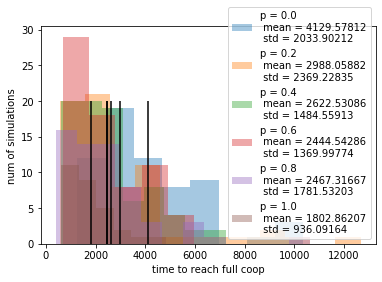

In [61]:
indice_lista = 0

means = list()
stds = list()

for lista in coops:
    tmp = list()
    indice = 0
    
    
    for item in lista[2]:
        if item:
            tmp.append(lista[1][indice])
        indice += 1
    
    if 1:#indice_lista == 0 or indice_lista == 5:
        print('sim that reach full coop (p={}) = {}'.format(round(ps[indice_lista], 3), len(tmp)))
        sns.distplot(tmp, kde=False, label='p = {}\n mean = {}\n std = {}'.format(round(ps[indice_lista], 2), round(np.mean(tmp), 5), round(np.std(tmp), 5)))
        
        means.append(np.mean(tmp))
        stds.append(np.std(tmp))
        
        plt.vlines(np.mean(tmp), 0, 20)
    plt.legend(loc='best')
    plt.xlabel('time to reach full coop')
    plt.ylabel('num of simulations')
    
    indice_lista += 1

#plt.figure(figsize=(10,10), dpi=300)

Text(0, 0.5, 'rounds')

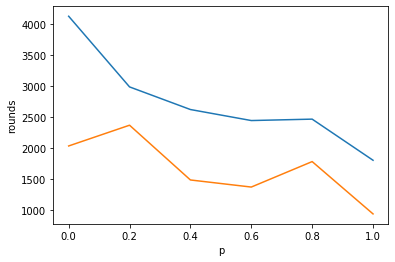

In [53]:
plt.plot(ps, means, label='mean')
plt.plot(ps, stds, label='std')
plt.xlabel('p')
plt.ylabel('rounds')

Text(0.5, 0, 'p')

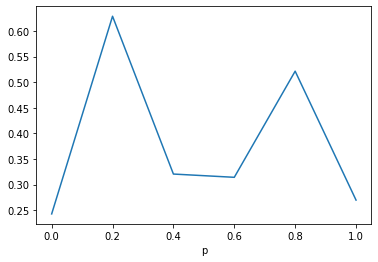

In [56]:
cvs = [stds[i]**2/means[i]**2 for i in range(len(ps))]
plt.plot(ps, cvs)
plt.xlabel('p')

# Find w

100%|██████████| 1000/1000 [00:00<00:00, 7246.38it/s]


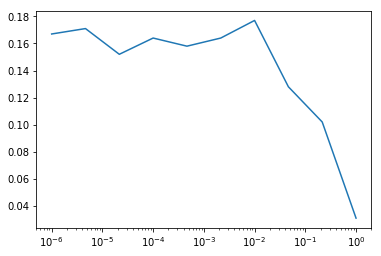

In [150]:
ws = np.logspace(-6, 0, 10)
res_w = list()
for w in ws:
    res_w.append(runModel(1000, n = 10, p=0, w=w, b=5, all_coop=False))
    
plt.plot(ws, res_w)
plt.xscale("log")

100%|██████████| 1000/1000 [00:00<00:00, 2223.86it/s]


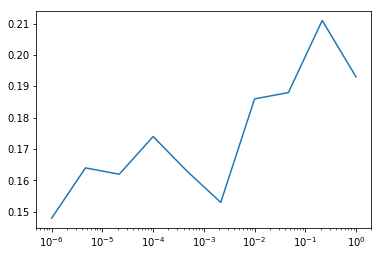

In [152]:
ws = np.logspace(-6, 0, 10)
res_w = list()
for w in ws:
    res_w.append(runModel(1000, n = 10, p=0, w=w, b=5, all_coop=True))
    
plt.plot(ws, res_w)
plt.xscale("log")

# How is the relationship coop~p

In [14]:
ps = np.arange(0, 1, 0.1)
coops = [runModel(5000, n=30, p=p, w=0.01, b=5, all_coop=False) for p in ps]


 76%|███████▌  | 3793/5000 [00:52<00:19, 61.45it/s]Process ForkPoolWorker-260:
Process ForkPoolWorker-257:
Process ForkPoolWorker-258:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-6-e5acbb794d7f>", line 10, in _runModel
    c.make_action()
Traceback (most recen

KeyboardInterrupt: 

In [15]:
plt.plot(ps, coops)

NameError: name 'coops' is not defined


 76%|███████▌  | 3793/5000 [01:06<00:19, 61.45it/s]

In [ ]:
ps = np.arange(0, 1, 0.1)
coops = [runModel(5000, n=30, p=p, w=0.01, b=5, all_coop=True) for p in ps]


 78%|███████▊  | 3907/5000 [00:48<00:18, 59.70it/s]

In [ ]:
plt.plot(ps, coops)

# Intersection

In [10]:
def coopBigger(b, p):
    fixDef = runModel(5000, n=20, p=p, w=0.01, b=b, all_coop=True)
    fixCoop = runModel(5000, n=20, p=p, w=0.01, b=b, all_coop=False)
    
    return fixCoop>fixDef


In [11]:
def runBinary(p, startingB):
    in_left = False
    
    b = startingB
    while True:
        if coopBigger(b, p):
            break
        in_left = True
        b = b*2
    
    if not in_left: raise
    a = b/2
    
    while (b-a > 1):
        print((a,b))
        m = (b+a)/2
        if coopBigger(m, p):
            b = m
        else:
            a = m
    
    print((f"final res {m} with {p}"))       
    return m

In [13]:
[runBinary(i, 3) for i in np.flip(np.arange(0, 1, 0.33))]

 63%|██████▎   | 3163/5000 [00:10<00:07, 260.93it/s]Process ForkPoolWorker-244:
Process ForkPoolWorker-242:
Process ForkPoolWorker-241:
Process ForkPoolWorker-243:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [25]:
fix_def = list()
bs = np.arange(5, 8, 1)
for b in bs:
    fix_def.append(runModel(5000, n=20, p=0, w=0.01, b=b, all_coop=True))
    
fix_coop = list()
for b in bs:
    fix_coop.append(runModel(5000, n=20, p=0, w=0.01, b=b, all_coop=False))

100%|██████████| 5000/5000 [00:07<00:00, 630.91it/s]


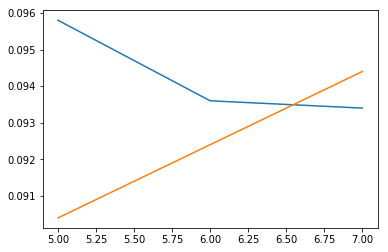

In [26]:
plt.plot(bs, fix_def)
plt.plot(bs, fix_coop)

In [36]:
fix_coop = list()
bs = np.arange(0, 6, 0.5)
bs = np.arange(0, 50, 5)

for b in bs:
    fix_coop.append(runModel(10000, n=50, p=0, w=0.5, b=b, all_coop=False))

100%|██████████| 10000/10000 [00:44<00:00, 226.48it/s]


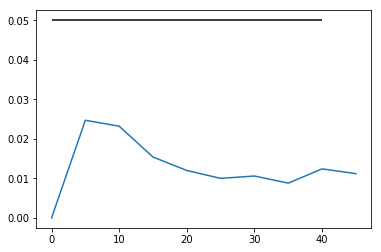

In [39]:
plt.plot(bs, fix_coop)
plt.hlines(0.05, 0, 40)

In [18]:
fix_def = list()
bs = np.arange(0, 20, 2)
for b in bs:
    fix_def.append(runModel(5000, n = 10, p=0, w=0.01, b=b, all_coop=True))

100%|██████████| 5000/5000 [00:02<00:00, 1983.50it/s]


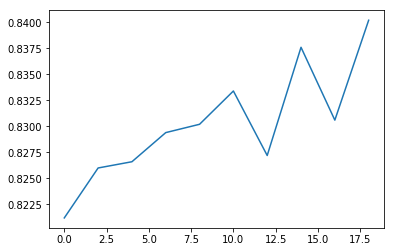

In [19]:
plt.plot(bs, fix_def)

Text(0, 0.5, 'num of cooperators')

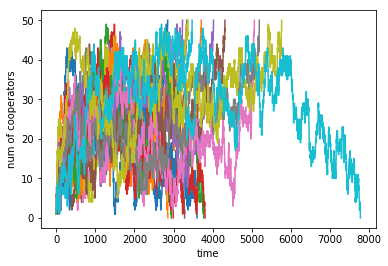

In [22]:
r_long = sorted(r, key = lambda a: len(a))[-20:]

for path in r_long:
    plt.plot(path)
    
plt.xlabel('time')
plt.ylabel('num of cooperators')
#plt.title('fuck off we dont know you', fontsize=70)
#plt.savefig('goodone.eps', format='eps', dpi=1000)